In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
timeseries_df = pd.read_csv('/home/npruitt/repos/csv_files/express_app_load_test_timeseries_data.csv')

In [3]:
timeseries_df.head()

,metric_name,timestamp,metric_value,check,error,error_code,expected_response,group,method,name,proto,scenario,service,status,subproto,tls_version,url,extra_tags,metadata
0,http_reqs,1690667868,1.000000,NaN,NaN,NaN,True,NaN,GET,http://127.0.0.1:3000/person/1,HTTP/1.1,default,NaN,200.0,NaN,NaN,http://127.0.0.1:3000/person/1,NaN,NaN
1,http_req_duration,1690667868,30.533006,NaN,NaN,NaN,True,NaN,GET,http://127.0.0.1:3000/person/1,HTTP/1.1,default,NaN,200.0,NaN,NaN,http://127.0.0.1:3000/person/1,NaN,NaN
2,http_req_blocked,1690667868,0.510090,NaN,NaN,NaN,True,NaN,GET,http://127.0.0.1:3000/person/1,HTTP/1.1,default,NaN,200.0,NaN,NaN,http://127.0.0.1:3000/person/1,NaN,NaN
3,http_req_connecting,1690667868,0.326767,NaN,NaN,NaN,True,NaN,GET,http://127.0.0.1:3000/person/1,HTTP/1.1,default,NaN,200.0,NaN,NaN,http://127.0.0.1:3000/person/1,NaN,NaN
4,http_req_tls_handshaking,1690667868,0.000000,NaN,NaN,NaN,True,NaN,GET,http://127.0.0.1:3000/person/1,HTTP/1.1,default,NaN,200.0,NaN,NaN,http://127.0.0.1:3000/person/1,NaN,NaN


In [4]:
timeseries_df = timeseries_df[['metric_name', 'timestamp', 'metric_value']]

In [5]:
timeseries_df = timeseries_df[timeseries_df['metric_name'] == 'http_req_duration'][['timestamp', 'metric_value']]

In [6]:
http_duration_timeseries_df = timeseries_df.groupby(timeseries_df['timestamp']).median()

In [7]:
# create 'timestamp' column out of index
http_duration_timeseries_df = http_duration_timeseries_df.reset_index()

<Axes: xlabel='timestamp'>

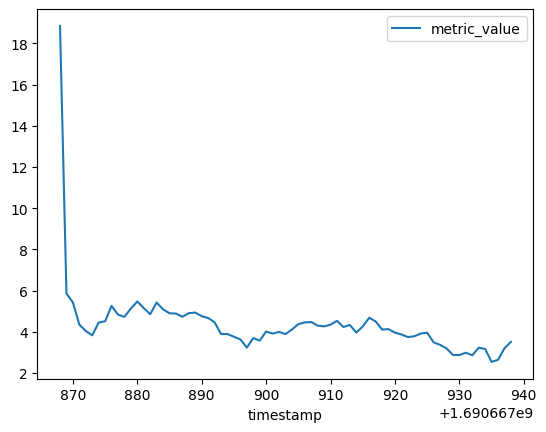

In [8]:
http_duration_timeseries_df.plot(x='timestamp', y='metric_value')

<function matplotlib.pyplot.show(close=None, block=None)>

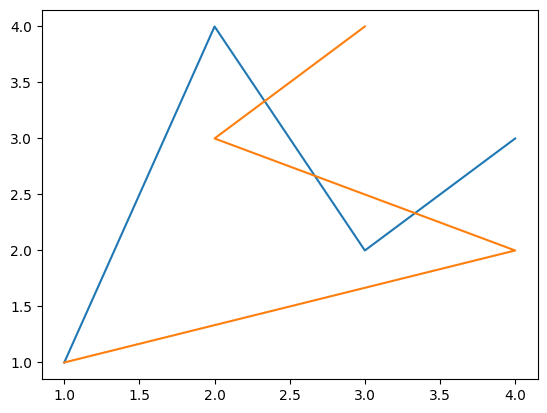

In [9]:
# Rudimentary timeseries plot. Can I use matplotlib to create a better one with the x-axis tick marks to be 'seconds'
# into test?
# subplot creates a single sublpt - subplots returns an axes or array of axes
# Below example creates two lines on same chart! I'll want to do this for load testing.
fig, ax = plt.subplots(1, 1)
ax.plot([1, 2, 3, 4], [1, 4, 2,3])
ax.plot([1, 4, 2,3], [1, 2, 3, 4])
plt.subplots

plt.show


Text(0.5, 0, 'Time Elapsed (s)')

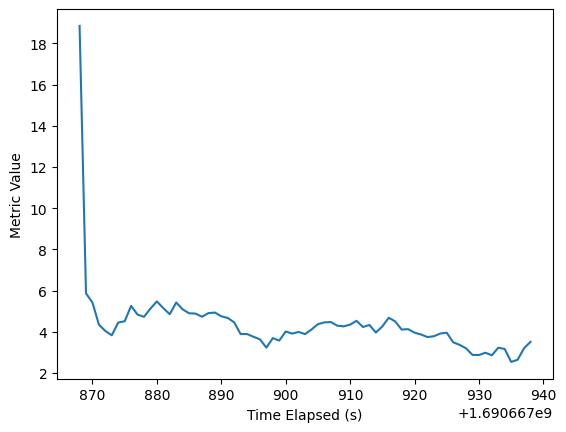

In [10]:
fig, ax = plt.subplots(1,1)
ax.plot(http_duration_timeseries_df['timestamp'], http_duration_timeseries_df['metric_value'])
ax.set_ylabel('Metric Value')
ax.set_xlabel('Time Elapsed (s)')

In [11]:
timeseries = http_duration_timeseries_df['timestamp']

In [17]:
timeseries_start_time = timeseries[0]
timeseries = timeseries.apply(lambda x: x - timeseries_start_time)

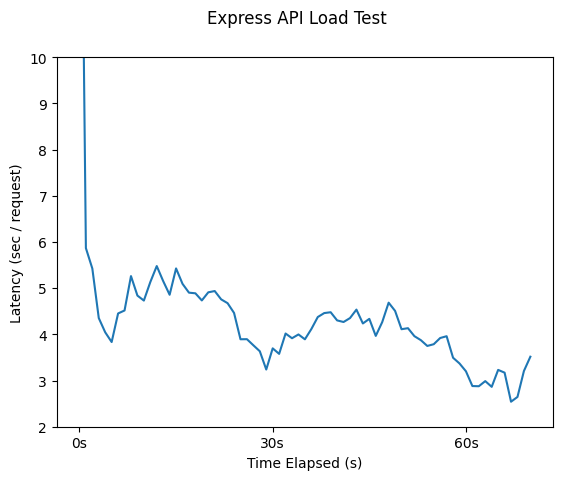

In [37]:
fig, ax = plt.subplots(1,1)
ax.plot(timeseries, http_duration_timeseries_df['metric_value'])
ax.set_ylabel('Latency (sec / request)')
ax.set_xlabel('Time Elapsed (s)')
ax.set_xticks([0, 30, 60], labels=['0s', '30s', '60s'])
ax.set_yticks([2, 3, 4, 5,6, 7, 8, 9, 10])
ax.set_ylim(2, 10)
fig.suptitle('Express API Load Test')
plt.show()

In [20]:
ax.get_xticklabels()

[Text(-10.0, 0, '−10'),
 Text(0.0, 0, '0'),
 Text(10.0, 0, '10'),
 Text(20.0, 0, '20'),
 Text(30.0, 0, '30'),
 Text(40.0, 0, '40'),
 Text(50.0, 0, '50'),
 Text(60.0, 0, '60'),
 Text(70.0, 0, '70'),
 Text(80.0, 0, '80')]